In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.6) # Added dropout layer
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = SimpleMLP(input_size=784, hidden_size=512, num_classes=10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


SimpleMLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.6, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [39]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders for stochastic gradient descent
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

In [40]:
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.05) # Try lr=0.05 and n_epochs=1

model.train() # prep model for training (enables dropout)

SimpleMLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.6, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [41]:
for epoch in range(40):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}: Accuracy: {accuracy:.2f}%')


Epoch 1: Accuracy: 94.48%
Epoch 2: Accuracy: 96.14%
Epoch 3: Accuracy: 96.90%
Epoch 4: Accuracy: 97.33%
Epoch 5: Accuracy: 97.52%
Epoch 6: Accuracy: 97.57%
Epoch 7: Accuracy: 97.69%
Epoch 8: Accuracy: 97.81%
Epoch 9: Accuracy: 97.97%
Epoch 10: Accuracy: 97.95%
Epoch 11: Accuracy: 97.95%
Epoch 12: Accuracy: 98.05%
Epoch 13: Accuracy: 98.10%
Epoch 14: Accuracy: 98.07%
Epoch 15: Accuracy: 98.14%
Epoch 16: Accuracy: 98.16%
Epoch 17: Accuracy: 98.19%
Epoch 18: Accuracy: 98.15%
Epoch 19: Accuracy: 98.28%
Epoch 20: Accuracy: 98.19%
Epoch 21: Accuracy: 98.42%
Epoch 22: Accuracy: 98.34%
Epoch 23: Accuracy: 98.31%
Epoch 24: Accuracy: 98.39%
Epoch 25: Accuracy: 98.27%
Epoch 26: Accuracy: 98.39%
Epoch 27: Accuracy: 98.37%
Epoch 28: Accuracy: 98.45%
Epoch 29: Accuracy: 98.35%
Epoch 30: Accuracy: 98.40%
Epoch 31: Accuracy: 98.39%
Epoch 32: Accuracy: 98.45%
Epoch 33: Accuracy: 98.43%
Epoch 34: Accuracy: 98.39%
Epoch 35: Accuracy: 98.44%
Epoch 36: Accuracy: 98.51%


KeyboardInterrupt: 

Задание 2

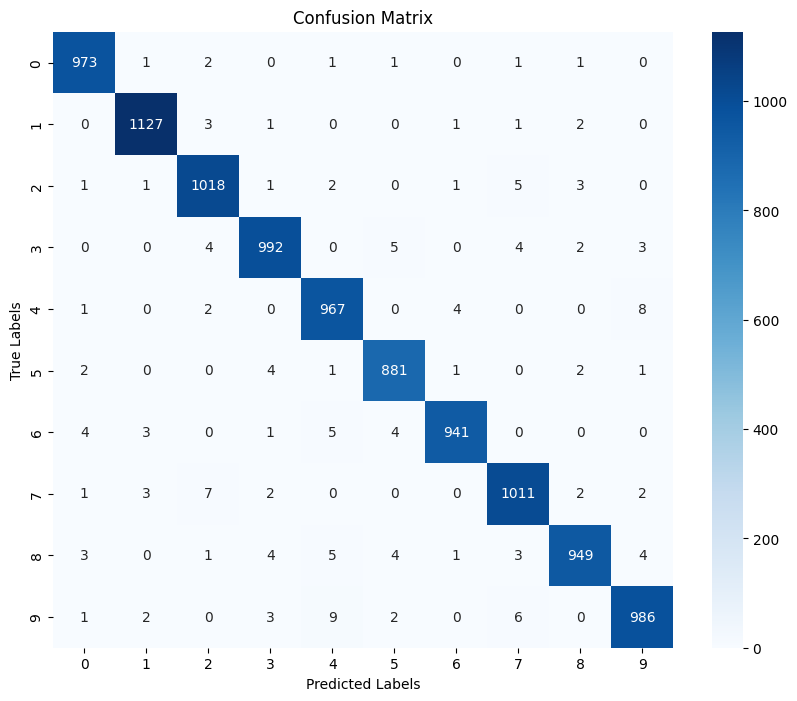

Метрики для цифры 5:
Accuracy:  0.9973
Precision: 0.9822
Recall:    0.9877
True Positives:  881
False Positives: 16
False Negatives: 11


In [44]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, pred = torch.max(output, 1)
        all_predictions.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

cm = confusion_matrix(all_targets, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

digit_to_analyze = 5
TP = cm[digit_to_analyze, digit_to_analyze]
FP = cm[:, digit_to_analyze].sum() - TP
FN = cm[digit_to_analyze, :].sum() - TP
TN = cm.sum() - TP - FP - FN

accuracy = (TP + TN) / cm.sum()
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f"Метрики для цифры {digit_to_analyze}:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"True Positives:  {TP}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")